In [1]:
import sys
from IPython.display import Image
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


# Utilities

In [2]:
num_epochs = 50
minibatch_size = 100


def minibatch_generator(X, y, minibatch_size):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)

    for start_idx in range(0, indices.shape[0] - minibatch_size 
                           + 1, minibatch_size):
        batch_idx = indices[start_idx:start_idx + minibatch_size]
        
        yield X.iloc[batch_idx], y.iloc[batch_idx]
        
def sigmoid(z):                                        
    return 1. / (1. + np.exp(-z))

def mse_loss(targets, probas, num_labels=10):
    onehot_targets = int_to_onehot(targets, num_labels=num_labels)
    return np.mean((onehot_targets - probas)**2)

def accuracy(targets, predicted_labels):
    return np.mean(predicted_labels == targets) 

def int_to_onehot(y, num_labels):

    ary = np.zeros((y.shape[0], num_labels))
    for i, val in enumerate(y):
        ary[i, val] = 1

    return ary

def compute_mse_and_acc(nnet, X, y, num_labels=10, minibatch_size=100):
    mse, correct_pred, num_examples = 0., 0, 0
    minibatch_gen = minibatch_generator(X, y, minibatch_size)
        
    for i, (features, targets) in enumerate(minibatch_gen):

        _, probas = nnet.forward(features)
        predicted_labels = np.argmax(probas, axis=1)
        
        onehot_targets = int_to_onehot(targets, num_labels=num_labels)
        loss = np.mean((onehot_targets - probas)**2)
        correct_pred += (predicted_labels == targets).sum()
        
        num_examples += targets.shape[0]
        mse += loss

    mse = mse/(i+1)
    acc = correct_pred/num_examples
    return mse, acc

def train(model, X_train, y_train, X_valid, y_valid, num_epochs,
          learning_rate=0.1):
    
    epoch_loss = []
    epoch_train_acc = []
    epoch_valid_acc = []
    
    for e in range(num_epochs):

        # iterate over minibatches
        minibatch_gen = minibatch_generator(
            X_train, y_train, minibatch_size)

        for X_train_mini, y_train_mini in minibatch_gen:
            
            #### Compute outputs ####
            a_h, a_out = model.forward(X_train_mini)

            #### Compute gradients ####
            d_loss__d_w_out, d_loss__d_b_out, d_loss__d_w_h, d_loss__d_b_h = \
                model.backward(X_train_mini, a_h, a_out, y_train_mini)

            #### Update weights ####
            model.weight_h -= learning_rate * d_loss__d_w_h
            model.bias_h -= learning_rate * d_loss__d_b_h
            model.weight_out -= learning_rate * d_loss__d_w_out
            model.bias_out -= learning_rate * d_loss__d_b_out
        
        #### Epoch Logging ####        
        train_mse, train_acc = compute_mse_and_acc(model, X_train, y_train)
        valid_mse, valid_acc = compute_mse_and_acc(model, X_valid, y_valid)
        train_acc, valid_acc = train_acc*100, valid_acc*100
        epoch_train_acc.append(train_acc)
        epoch_valid_acc.append(valid_acc)
        epoch_loss.append(train_mse)
        print(f'Epoch: {e+1:03d}/{num_epochs:03d} '
              f'| Train MSE: {train_mse:.2f} '
              f'| Train Acc: {train_acc:.2f}% '
              f'| Valid Acc: {valid_acc:.2f}%')

    return epoch_loss, epoch_train_acc, epoch_valid_acc

## Single Layer Neural Network



In [11]:
##########################
### MODEL
##########################

class NeuralNetMLP:

    def __init__(self, num_features, num_hidden, num_classes, random_seed=123):
        super().__init__()
        
        self.num_classes = num_classes
        
        # hidden
        rng = np.random.RandomState(random_seed)
        
        self.weight_h = rng.normal(
            loc=0.0, scale=0.1, size=(num_hidden, num_features))
        self.bias_h = np.zeros(num_hidden)
        
        # output
        self.weight_out = rng.normal(
            loc=0.0, scale=0.1, size=(num_classes, num_hidden))
        self.bias_out = np.zeros(num_classes)
        
    def forward(self, x):
        # Hidden layer
        # input dim: [n_examples, n_features] dot [n_hidden, n_features].T
        # output dim: [n_examples, n_hidden]
        z_h = np.dot(x, self.weight_h.T) + self.bias_h
        a_h = sigmoid(z_h)

        # Output layer
        # input dim: [n_examples, n_hidden] dot [n_classes, n_hidden].T
        # output dim: [n_examples, n_classes]
        z_out = np.dot(a_h, self.weight_out.T) + self.bias_out
        a_out = sigmoid(z_out)
        return a_h, a_out

    def backward(self, x, a_h, a_out, y):  
    
        #########################
        ### Output layer weights
        #########################
        
        # onehot encoding
        y_onehot = int_to_onehot(y, self.num_classes)

        # Part 1: dLoss/dOutWeights
        ## = dLoss/dOutAct * dOutAct/dOutNet * dOutNet/dOutWeight
        ## where DeltaOut = dLoss/dOutAct * dOutAct/dOutNet
        ## for convenient re-use
        
        # input/output dim: [n_examples, n_classes]
        d_loss__d_a_out = 2.*(a_out - y_onehot) / y.shape[0]

        # input/output dim: [n_examples, n_classes]
        d_a_out__d_z_out = a_out * (1. - a_out) # sigmoid derivative

        # output dim: [n_examples, n_classes]
        delta_out = d_loss__d_a_out * d_a_out__d_z_out # "delta (rule) placeholder"

        # gradient for output weights
        
        # [n_examples, n_hidden]
        d_z_out__dw_out = a_h
        
        # input dim: [n_classes, n_examples] dot [n_examples, n_hidden]
        # output dim: [n_classes, n_hidden]
        d_loss__dw_out = np.dot(delta_out.T, d_z_out__dw_out)
        d_loss__db_out = np.sum(delta_out, axis=0)
        

        #################################        
        # Part 2: dLoss/dHiddenWeights
        ## = DeltaOut * dOutNet/dHiddenAct * dHiddenAct/dHiddenNet * dHiddenNet/dWeight
        
        # [n_classes, n_hidden]
        d_z_out__a_h = self.weight_out
        
        # output dim: [n_examples, n_hidden]
        d_loss__a_h = np.dot(delta_out, d_z_out__a_h)
        
        # [n_examples, n_hidden]
        d_a_h__d_z_h = a_h * (1. - a_h) # sigmoid derivative
        
        # [n_examples, n_features]
        d_z_h__d_w_h = x
        
        # output dim: [n_hidden, n_features]
        d_loss__d_w_h = np.dot((d_loss__a_h * d_a_h__d_z_h).T, d_z_h__d_w_h)
        d_loss__d_b_h = np.sum((d_loss__a_h * d_a_h__d_z_h), axis=0)

        return (d_loss__dw_out, d_loss__db_out, 
                d_loss__d_w_h, d_loss__d_b_h)

In [12]:
model = NeuralNetMLP(num_features=28*28,
                     num_hidden=50,
                     num_classes=10)

# Loading the Dataset

In [3]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score

# Load MNIST data
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist["data"], mnist["target"]

# Normalize the data
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X))

# Split into Train (70%) and Test (30%)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y)

y_train = y_train.astype(int)
y_test = y_test.astype(int)

In [14]:
train(
    model=model,
    X_train=X_train, y_train=y_train,
    X_valid=X_test, y_valid=y_test,
    num_epochs=50,
    learning_rate=0.1)


Epoch: 001/050 | Train MSE: 0.04 | Train Acc: 81.06% | Valid Acc: 80.75%
Epoch: 002/050 | Train MSE: 0.03 | Train Acc: 86.95% | Valid Acc: 86.36%
Epoch: 003/050 | Train MSE: 0.02 | Train Acc: 88.91% | Valid Acc: 88.10%
Epoch: 004/050 | Train MSE: 0.02 | Train Acc: 90.05% | Valid Acc: 89.21%
Epoch: 005/050 | Train MSE: 0.02 | Train Acc: 90.77% | Valid Acc: 89.86%
Epoch: 006/050 | Train MSE: 0.02 | Train Acc: 91.28% | Valid Acc: 90.39%
Epoch: 007/050 | Train MSE: 0.02 | Train Acc: 91.69% | Valid Acc: 90.87%
Epoch: 008/050 | Train MSE: 0.01 | Train Acc: 92.02% | Valid Acc: 91.20%
Epoch: 009/050 | Train MSE: 0.01 | Train Acc: 92.37% | Valid Acc: 91.42%
Epoch: 010/050 | Train MSE: 0.01 | Train Acc: 92.62% | Valid Acc: 91.58%
Epoch: 011/050 | Train MSE: 0.01 | Train Acc: 92.88% | Valid Acc: 91.76%
Epoch: 012/050 | Train MSE: 0.01 | Train Acc: 93.10% | Valid Acc: 91.92%
Epoch: 013/050 | Train MSE: 0.01 | Train Acc: 93.24% | Valid Acc: 92.04%
Epoch: 014/050 | Train MSE: 0.01 | Train Acc: 93.35

([0.04282639728006545,
  0.0277610991726987,
  0.022191518783310406,
  0.019270172401983768,
  0.01743388841364361,
  0.016139486085460484,
  0.015169473846074347,
  0.014396058829592093,
  0.013766014290174263,
  0.013248017231538687,
  0.012784362645428449,
  0.012386164835011863,
  0.012027158898737214,
  0.011716041640485743,
  0.01142564649513075,
  0.011164390524425421,
  0.010920868944436024,
  0.01070279174625899,
  0.010492337179000335,
  0.010301807652593106,
  0.010120509335109521,
  0.009953092637913226,
  0.009794046640269697,
  0.009639245616112572,
  0.009500520319846313,
  0.00936291467328668,
  0.009231806833759518,
  0.009109614340485546,
  0.008990279767266839,
  0.008876200865165227,
  0.008770270771315716,
  0.008663651337345285,
  0.008564313439847666,
  0.00846794478966148,
  0.008373111770863447,
  0.00828183097130007,
  0.008194072188868886,
  0.008109730540335524,
  0.008029295112824287,
  0.007945770742426243,
  0.007868247138391179,
  0.0077937701677654935,


# Extending the Original Code to 2 Hidden Layers

In [4]:
import numpy as np

def sigmoid(z):                                        
    return 1. / (1. + np.exp(-z))

def int_to_onehot(y, num_labels):
    ary = np.zeros((y.shape[0], num_labels))
    for i, val in enumerate(y):
        ary[i, val] = 1
    return ary

def softmax(z):                                        
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))  # Stability adjustment
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

class NeuralNetMLP_TwoHidden:
    def __init__(self, num_features, num_hidden1, num_hidden2, num_classes, random_seed=123):
        super().__init__()
        
        self.num_classes = num_classes
        
        # Initialize weights for first hidden layer
        rng = np.random.RandomState(random_seed)
        self.weight_h1 = rng.normal(loc=0.0, scale=0.1, size=(num_hidden1, num_features))
        self.bias_h1 = np.zeros(num_hidden1)
        
        # Initialize weights for second hidden layer
        self.weight_h2 = rng.normal(loc=0.0, scale=0.1, size=(num_hidden2, num_hidden1))
        self.bias_h2 = np.zeros(num_hidden2)
        
        # Initialize weights for output layer
        self.weight_out = rng.normal(loc=0.0, scale=0.1, size=(num_classes, num_hidden2))
        self.bias_out = np.zeros(num_classes)
        
    def forward(self, x):
        # First Hidden Layer
        z_h1 = np.dot(x, self.weight_h1.T) + self.bias_h1
        a_h1 = sigmoid(z_h1)
        
        # Second Hidden Layer
        z_h2 = np.dot(a_h1, self.weight_h2.T) + self.bias_h2
        a_h2 = sigmoid(z_h2)
        
        # Output Layer
        z_out = np.dot(a_h2, self.weight_out.T) + self.bias_out
        # a_out = sigmoid(z_out)
        a_out = softmax(z_out)  # Use softmax instead of sigmoid
        return a_h1, a_h2, a_out

    def backward(self, x, a_h1, a_h2, a_out, y):  
        #########################
        ### Output layer weights
        #########################
        
        # One-hot encoding
        y_onehot = int_to_onehot(y, self.num_classes)

        # Compute gradient for output layer
        d_loss__d_z_out = (a_out - y_onehot) / y.shape[0]  # Combined gradient for softmax + cross-entropy
        delta_out = d_loss__d_z_out

        d_z_out__dw_out = a_h2
        d_loss__dw_out = np.dot(delta_out.T, d_z_out__dw_out)
        d_loss__db_out = np.sum(delta_out, axis=0)
        
        #########################
        ### Second Hidden Layer
        #########################
        d_z_out__a_h2 = self.weight_out
        d_loss__a_h2 = np.dot(delta_out, d_z_out__a_h2)
        d_a_h2__d_z_h2 = a_h2 * (1. - a_h2)
        delta_h2 = d_loss__a_h2 * d_a_h2__d_z_h2

        d_z_h2__dw_h2 = a_h1
        d_loss__dw_h2 = np.dot(delta_h2.T, d_z_h2__dw_h2)
        d_loss__db_h2 = np.sum(delta_h2, axis=0)
        
        #########################
        ### First Hidden Layer
        #########################
        d_z_h2__a_h1 = self.weight_h2
        d_loss__a_h1 = np.dot(delta_h2, d_z_h2__a_h1)
        d_a_h1__d_z_h1 = a_h1 * (1. - a_h1)
        delta_h1 = d_loss__a_h1 * d_a_h1__d_z_h1

        d_z_h1__dw_h1 = x
        d_loss__dw_h1 = np.dot(delta_h1.T, d_z_h1__dw_h1)
        d_loss__db_h1 = np.sum(delta_h1, axis=0)

        return (d_loss__dw_out, d_loss__db_out, 
                d_loss__dw_h2, d_loss__db_h2,
                d_loss__dw_h1, d_loss__db_h1)


    def update_params(self, grads, learning_rate):
        d_w_out, d_b_out, d_w_h2, d_b_h2, d_w_h1, d_b_h1 = grads
        self.weight_out -= learning_rate * d_w_out
        self.bias_out -= learning_rate * d_b_out
        self.weight_h2 -= learning_rate * d_w_h2
        self.bias_h2 -= learning_rate * d_b_h2
        self.weight_h1 -= learning_rate * d_w_h1
        self.bias_h1 -= learning_rate * d_b_h1

    def compute_loss(self, a_out, y):
        y_onehot = int_to_onehot(y, self.num_classes)
        loss = -np.sum(y_onehot * np.log(a_out + 1e-9)) / y.shape[0]
        return loss


In [14]:
from sklearn.metrics import roc_auc_score,accuracy_score
# Define network architecture
num_features = X_train.shape[1]  # 784 for MNIST
num_hidden1 = 128
num_hidden2 = 64
num_classes = 10

# Initialize the neural network
nn_model = NeuralNetMLP_TwoHidden(num_features, num_hidden1, num_hidden2, num_classes)

# Training parameters
epochs = 50
learning_rate = 0.1

# One-hot encode training labels for ROC AUC
y_train_onehot = int_to_onehot(y_train, num_classes)
preds = np.zeros((y_train_onehot.shape[0], num_classes))
actuals = np.zeros((y_train_onehot.shape[0], num_classes))
accuracy_scores = []
losses = []
two_hidden_loss_metric = []
loss_metric = 0
accuracies_2h = []
for epoch in range(epochs):
    for i, (X_train_mini, y_train_mini) in enumerate(minibatch_generator(X_train, y_train, minibatch_size)):
        
        # Forward pass
        a_h1, a_h2, a_out = nn_model.forward(X_train_mini)
        # Compute loss
        loss = nn_model.compute_loss(a_out, y_train_mini)
        losses.append(loss)
        accuracy_scores.append(accuracy_score(y_train_mini, np.argmax(a_out, axis=1)))
        # Backward pass
        grads = nn_model.backward(X_train_mini, a_h1, a_h2, a_out, y_train_mini)
        
        # Update parameters
        nn_model.update_params(grads, learning_rate)
        loss_metric += loss
        
    two_hidden_loss_metric.append(loss_metric/y_train.shape[0])
    accuracy = np.mean(accuracy_scores)
    loss = np.mean(losses)
    accuracies_2h.append(accuracy)
    if (epoch+1) % 10 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")

    accuracy_scores = []
    losses = []

Epoch 1/50, Loss: 1.4207, Accuracy: 0.6453
Epoch 10/50, Loss: 0.1843, Accuracy: 0.9472
Epoch 20/50, Loss: 0.1110, Accuracy: 0.9699
Epoch 30/50, Loss: 0.0694, Accuracy: 0.9824
Epoch 40/50, Loss: 0.0438, Accuracy: 0.9904
Epoch 50/50, Loss: 0.0279, Accuracy: 0.9952


# 3) Use the 2-layer neural network to classify the MNIST digits and evaluate the performance of the model

In [ ]:
# Validation Accuracy
a_h1, a_h2, a_out = nn_model.forward(X_test)
accuracy = accuracy_score(y_test, np.argmax(a_out, axis=1))
print(f"Validation Accuracy: {accuracy:.4f}")

Validation Accuracy: 0.9610


In [ ]:
# Forward pass on Test set
_, _, a_out_test = nn_model.forward(X_test)

# Compute Macro AUC
# Convert predictions and true labels to one-hot
y_test_onehot = int_to_onehot(y_test, num_classes)

# Since ROC AUC expects probabilities, use a_out_test
macro_auc = roc_auc_score(y_test_onehot, a_out_test, average='macro', multi_class='ovr')
print(f"Macro AUC on Test Set: {macro_auc:.4f}")


Macro AUC on Test Set: 0.9983


# 4) Comparing with a Pytorch Implementation

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

pytorchc_training_loss = []
# Define the model
class ANN_PyTorch(nn.Module):
    def __init__(self, input_size, hidden1, hidden2, num_classes):
        super(ANN_PyTorch, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden2, num_classes)
        # Removed Softmax activation

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        # Removed Softmax activation
        return out


# Initialize the model, loss function, and optimizer
model = ANN_PyTorch(num_features, 128, 64, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)
loss_metric = 0
acc_metric = 0
accuracy_scores_pytorch = []
# Training loop
for epoch in range(epochs):
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        # One-hot encode labels
        y_onehot = torch.zeros(batch_y.size(0), num_classes)
        y_onehot.scatter_(1, batch_y.unsqueeze(1), 1)
        loss = criterion(outputs, y_onehot)
        loss.backward()
        optimizer.step()
        loss_metric += loss.item()
        acc_metric += ((torch.argmax(outputs,dim=1) == batch_y).float().mean())



    accuracy_scores_pytorch.append(acc_metric/len(train_loader))
    pytorchc_training_loss.append(loss_metric/len(train_loader))


        
    if (epoch+1) % 10 == 0 or epoch == 0:
        print(f"[PyTorch] Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")



[PyTorch] Epoch 1/50, Loss: 0.2439
[PyTorch] Epoch 10/50, Loss: 0.0013
[PyTorch] Epoch 20/50, Loss: 0.0001
[PyTorch] Epoch 30/50, Loss: 0.0003
[PyTorch] Epoch 40/50, Loss: 0.0002
[PyTorch] Epoch 50/50, Loss: 0.0002


In [9]:
# Evaluation
model.eval()
with torch.no_grad():
    all_outputs = []
    all_labels = []
    for batch_X, batch_y in test_loader:
        outputs = model(batch_X)
        all_outputs.append(outputs.numpy())
        all_labels.append(batch_y.numpy())
        
    a_out_test_pytorch = np.vstack(all_outputs)
    y_test_pytorch = np.hstack(all_labels)
    y_test_onehot_pytorch = int_to_onehot(y_test_pytorch, num_classes)
    macro_auc_pytorch = roc_auc_score(y_test_onehot_pytorch, a_out_test_pytorch, average='macro', multi_class='ovr')
    accuracy_pytorch = accuracy_score(y_test_pytorch, np.argmax(a_out_test_pytorch, axis=1))
    print(f"[PyTorch] Validation Accuracy: {accuracy_pytorch:.4f}")
    print(f"[PyTorch] Macro AUC on Test Set: {macro_auc_pytorch:.4f}")



[PyTorch] Validation Accuracy: 0.9735
[PyTorch] Macro AUC on Test Set: 0.9953


In [10]:
# Turn cumulative back to reg
two_hidden_loss_metric_non_cum = np.diff(two_hidden_loss_metric)
pytorchc_training_loss_non_cum = np.diff(pytorchc_training_loss)
accuracy_scores_pytorch_non_cum = np.diff(accuracy_scores_pytorch)

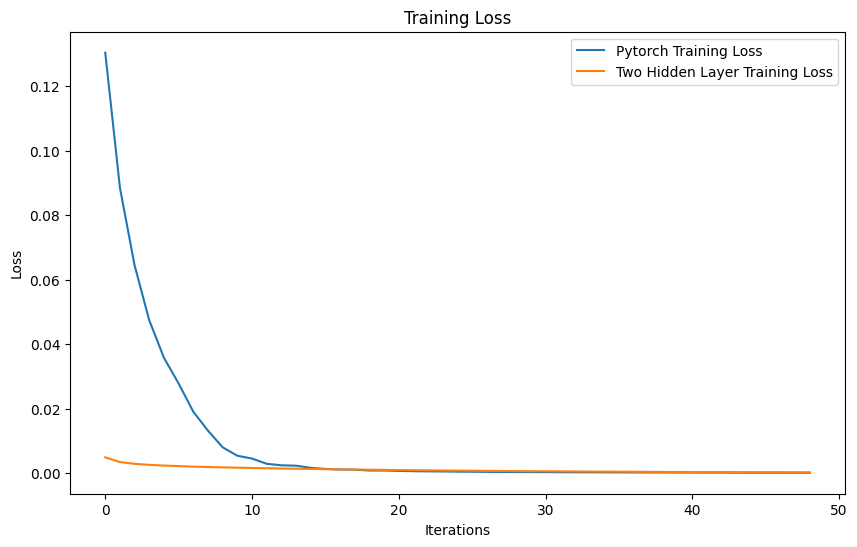

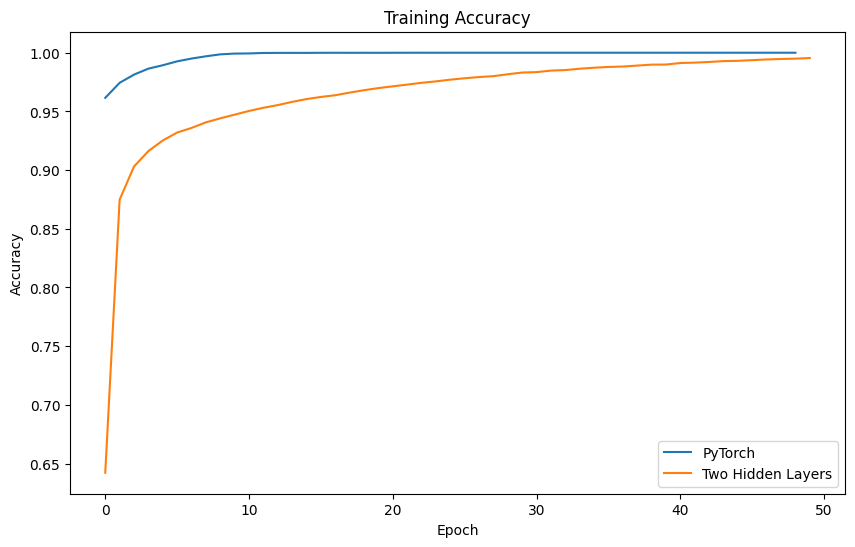

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(pytorchc_training_loss_non_cum,label = "Pytorch Training Loss")
plt.plot(two_hidden_loss_metric_non_cum,label = "Two Hidden Layer Training Loss")
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

# Plot accuracies
plt.figure(figsize=(10, 6))
# plt.plot(epoch_train_acc, label='Single Hidden Layer')
plt.plot(accuracy_scores_pytorch_non_cum, label='PyTorch')
plt.plot(accuracies_2h, label='Two Hidden Layers')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()
plt.show()

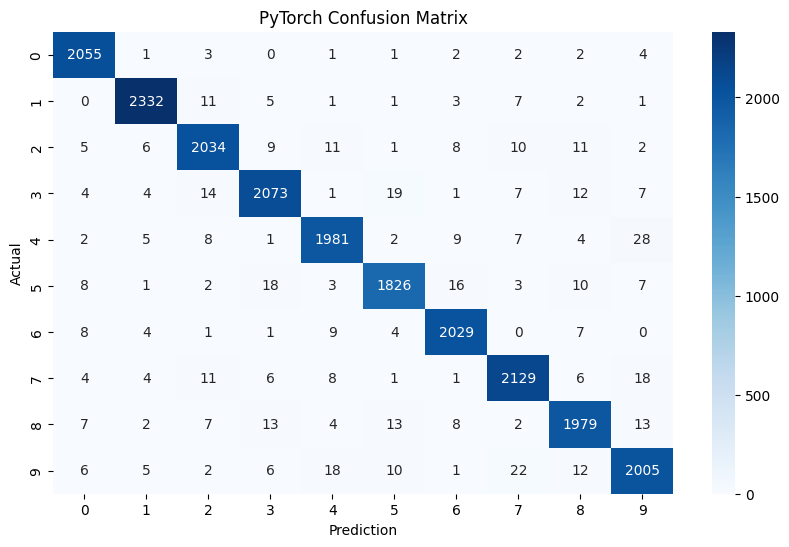

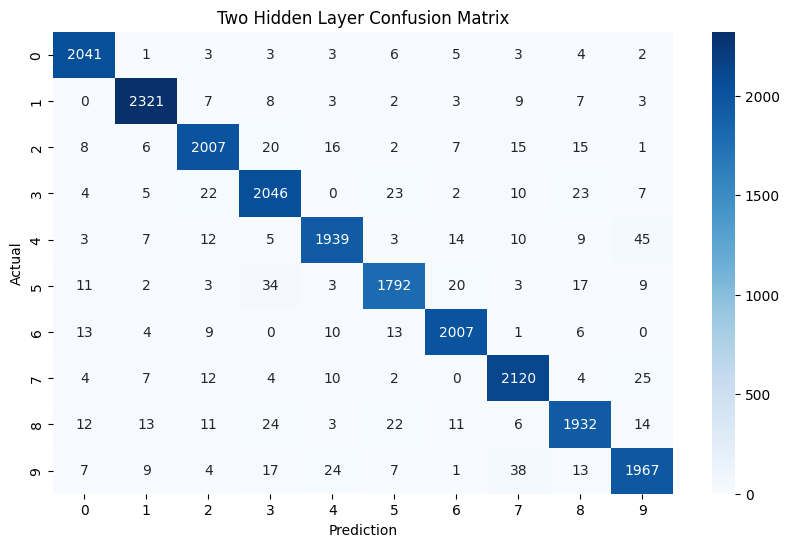

In [15]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# PyTorch
y_pred_pytorch = np.argmax(a_out_test_pytorch, axis=1)
cm_pytorch = confusion_matrix(y_test_pytorch, y_pred_pytorch)
plt.figure(figsize=(10, 6))
sns.heatmap(cm_pytorch, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.title('PyTorch Confusion Matrix')
plt.show()

# Two Hidden Layers
_, _, a_out = nn_model.forward(X_test)
y_pred = np.argmax(a_out, axis=1)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.title('Two Hidden Layer Confusion Matrix')
plt.show()


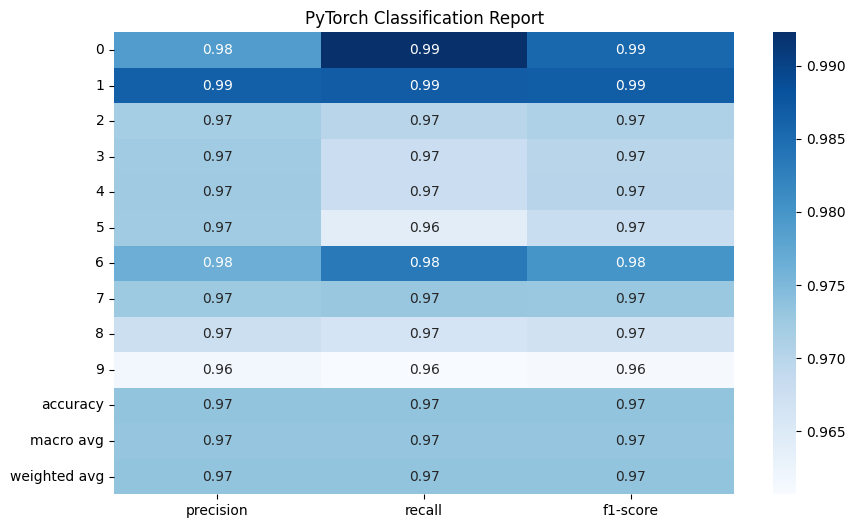

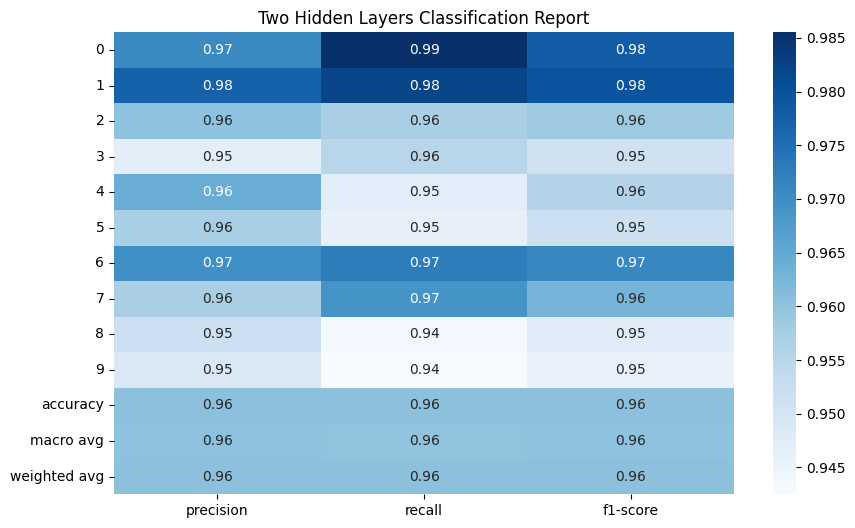

In [20]:
# Classification Report with Seaborn
from sklearn.metrics import classification_report

# PyTorch plot -cls report
plt.figure(figsize=(10, 6))
sns.heatmap(pd.DataFrame(classification_report(y_test_pytorch, y_pred_pytorch, output_dict=True)).iloc[:-1, :].T, annot=True,cmap='Blues')
plt.title('PyTorch Classification Report')
plt.show()

# Two Hidden Layers plot -cls report
plt.figure(figsize=(10, 6))
sns.heatmap(pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).iloc[:-1, :].T, annot=True,cmap='Blues')
plt.title('Two Hidden Layers Classification Report')
plt.show()




